# 전이학습
https://codetorial.net/tensorflow/transfer_learning.html

### Tensorflow 공식 문서
https://www.tensorflow.org/lite/tutorials/model_maker_image_classification

### Pre-trained model download
https://tfhub.dev/tensorflow/efficientnet/b4/classification/1

### EfficientNet
https://norman3.github.io/papers/docs/efficient_net.html
https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite

In [21]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

try:
  # %tensorflow_version은 Colab에서만 지원됩니다.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

### Mobilenet 이용한 전이학습
https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko

### 1. 데이터 로드

In [23]:
data_dir = './food100'

In [24]:
IMAGE_SHAPE = (224,224)

우리의 데이터 세트는 전처리를 수동으로 여러번에 걸쳐 했으나 여전히 부족하므로,<br>
데이터 증식(Data Augmentation) 과정이 필요하다.<br>
<br>
데이터 증식에 관련된 여러가지 인자들은 다음 keras 공식 문서에서 확인할 수 있다.<br>
https://keras.io/api/preprocessing/image/
<br>
- rotation_range: 이미지 회전 범위 (degrees)
- width_shift, height_shift: 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
- rescale: 원본 영상은 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높습니다 (통상적인 learning rate를 사용할 경우). 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜줍니다. 이는 다른 전처리 과정에 앞서 가장 먼저 적용됩니다.
- shear_range: 임의 전단 변환 (shearing transformation) 범위
- zoom_range: 임의 확대/축소 범위
- horizontal_flip: True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집습니다. 원본 이미지에 수평 비대칭성이 없을 때 효과적입니다. 즉, 뒤집어도 자연스러울 때 사용하면 좋습니다.
- fill_mode 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
image_generator = ImageDataGenerator(
#         rotation_range=15,
        rescale=1./255)

In [26]:
# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

image_data = image_generator.flow_from_directory(str(data_dir), target_size=IMAGE_SHAPE)

Found 28438 images belonging to 100 classes.


In [27]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 100)


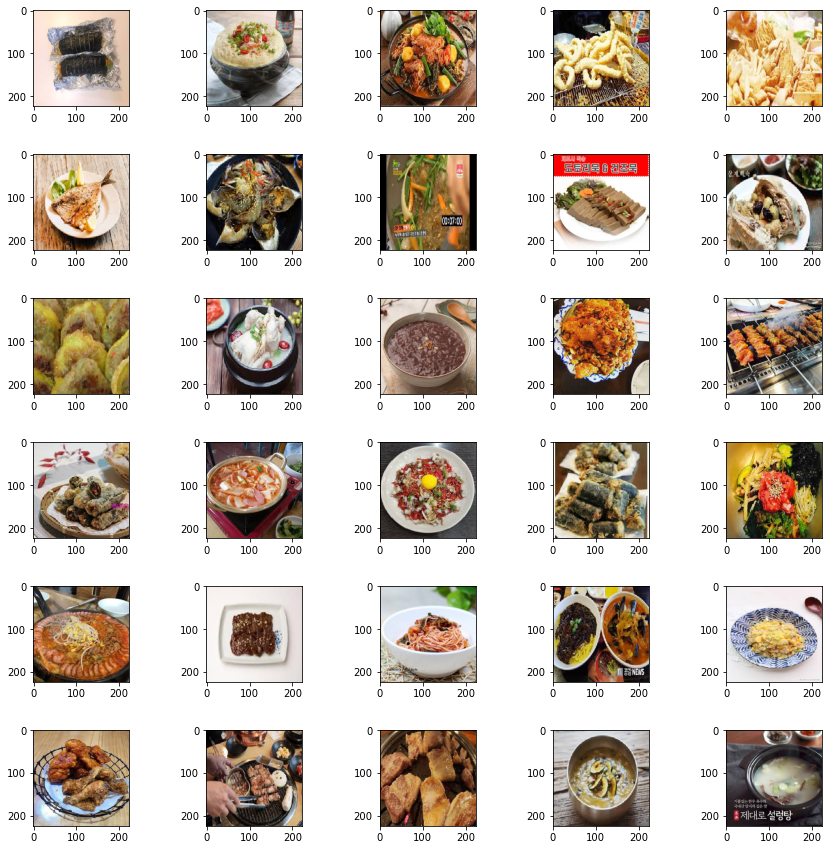

In [28]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])

### 2. 미리 훈련된 가중치

In [29]:
import matplotlib.pylab as plt

import tensorflow as tf

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

In [30]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [31]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [32]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면 새로운 분류 계층만 변경시킬 수 있음

In [33]:
feature_extractor_layer.trainable = False

### 3. 새로운 분류 계층 추가

#### 하이퍼 파라미터 튜닝
- epoch : 전이학습 시 몇 epoch에서 정확도가 유지되는 지 실험 (20 to 100)
- dropout : 0.1,0.2,0.3,0.4,0.5 에서 각각 몇 퍼센트의 정확도를 보이는 지 실험
- data_augmentation : 어떤 비율로 데이터 증식을 했을 때 가장 높은 정확도를 보이는 지 실험
- Dense layer : 몇단계로 쌓을 시 가장 높은 정확도를 보이는 지 실험(1 to 3)

#### 데이터 증식

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### 분류 계층 추가

In [34]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dropout(0.2),
#   data_augmentation,
  layers.Dense(512, activation = 'relu'),
  layers.Dense(image_data.num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               51300     
Total params: 2,965,156
Trainable params: 707,172
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
predictions = model(image_batch)

In [36]:
predictions.shape

TensorShape([32, 100])

### 4. 모델 학습

In [37]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [38]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [39]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=50,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/50
889/889 [==============================] - 405s 451ms/step - loss: 2.4096 - acc: 0.3909
Epoch 2/50
889/889 [==============================] - 391s 440ms/step - loss: 1.6996 - acc: 0.5389
Epoch 3/50
889/889 [==============================] - 385s 433ms/step - loss: 1.4628 - acc: 0.5986
Epoch 4/50
889/889 [==============================] - 395s 444ms/step - loss: 1.2900 - acc: 0.6374
Epoch 5/50
889/889 [==============================] - 390s 439ms/step - loss: 1.1366 - acc: 0.6780
Epoch 6/50
889/889 [==============================] - 387s 435ms/step - loss: 1.0150 - acc: 0.7014
Epoch 7/50
889/889 [==============================] - 377s 424ms/step - loss: 0.9081 - acc: 0.7280
Epoch 8/50
889/889 [==============================] - 381s 429ms/step - loss: 0.8019 - acc: 0.7565
Epoch 9/50
889/889 [==============================] - 391s 440ms/step - loss: 0.7265 - acc: 0.7785
Epoch 10/50
889/889 [==============================] - 390s 439ms/step - loss: 0.6456 - acc: 0.8006
Epoch 11/

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               51300     
Total params: 2,965,156
Trainable params: 707,172
Non-trainable params: 2,257,984
_________________________________________________________________


### 5. LOSS 확인

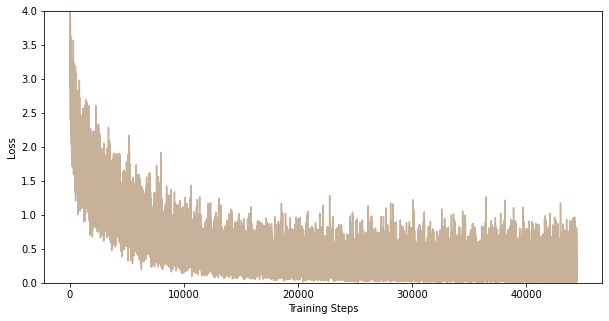

In [41]:
plt.figure(figsize=(10,5))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(batch_stats_callback.batch_losses, color = '#c7b198')

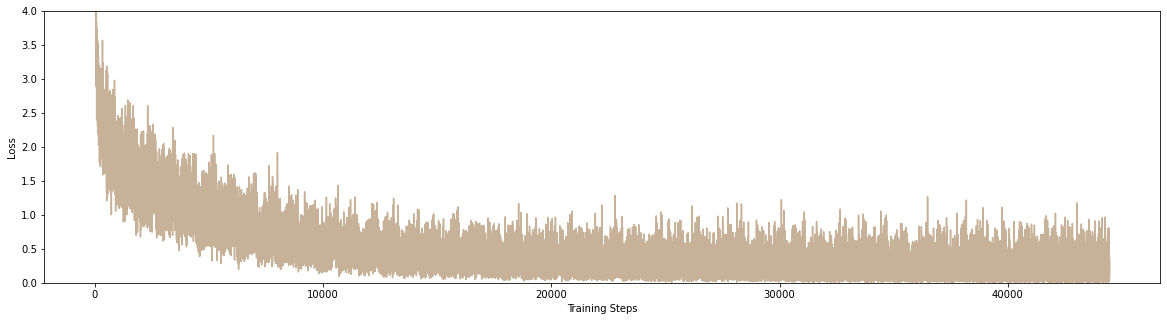

In [42]:
plt.figure(figsize=(20,5))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(batch_stats_callback.batch_losses, color = '#c7b198')

### 6. 정확도 확인

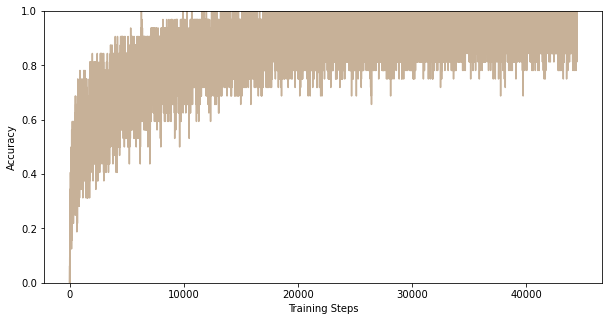

In [43]:
plt.figure(figsize=(10,5))
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc, color = '#c7b198')

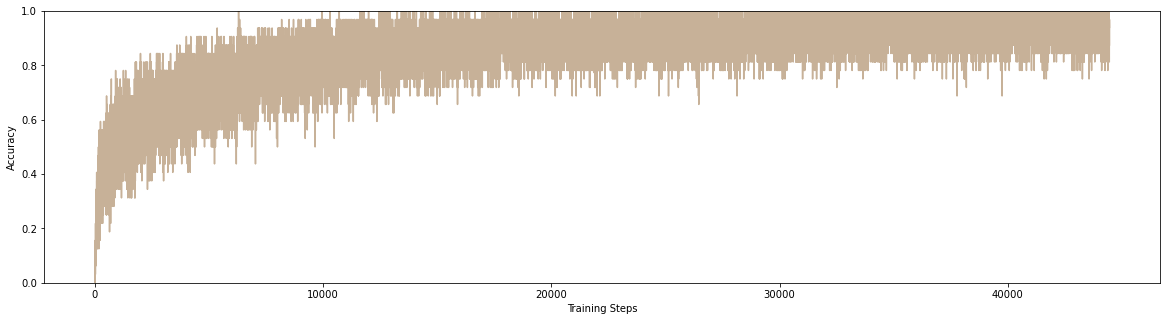

In [44]:
plt.figure(figsize=(20,5))
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc, color = '#c7b198')

### 7. 예측확인

In [45]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['간장 치킨', '간장게장', '갈비', '갈비찜', '갈치구이', '감자전', '감자탕', '계란 볶음밥',
       '계란찜', '고구마 맛탕', '고구마 튀김', '고등어 구이', '고등어감자조림', '곱창', '국물 떡볶이',
       '김말이 튀김', '김밥', '김치 볶음밥', '김치말이 국수', '김치전', '김치찌개', '깐풍기', '꿔바로우',
       '낙지볶음', '너비아니', '닭갈비', '닭발', '닭볶음탕', '도토리묵', '동그랑땡', '돼지불백',
       '된장찌개', '떡갈비', '떡국', '라면', '마라탕', '만두', '만두 튀김', '메밀국수', '물냉면',
       '미역국', '보쌈', '부대찌개', '불고기', '비빔 냉면', '비빔국수', '비빔밥', '산적', '삼겹살',
       '삼계탕', '새우 튀김', '새우볶음밥', '설렁탕', '소고기', '소고기무국', '소고기죽', '순대',
       '순두부찌개', '시레깃국', '신선로', '아구찜', '야채 튀김', '야채죽', '양꼬치', '양념 치킨',
       '양념게장', '양장피', '어묵', '오징어 튀김', '우동', '유산슬', '육개장', '육전', '육회',
       '잔치국수', '잡채', '쟁반국수', '전복죽', '제육볶음', '족발', '짜장 떡볶이', '짜장면', '짬뽕',
       '쫄면', '청국장', '초밥', '추어탕', '칼국수', '케이크', '콩국수', '콩나물국밥', '크림 떡볶이',
       '탕평채', '팔보채', '팥죽', '피자', '해물파전', '호박죽', '회', '후라이드 치킨'],
      dtype='<U7')

In [46]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [47]:
label_id = np.argmax(label_batch, axis=-1)

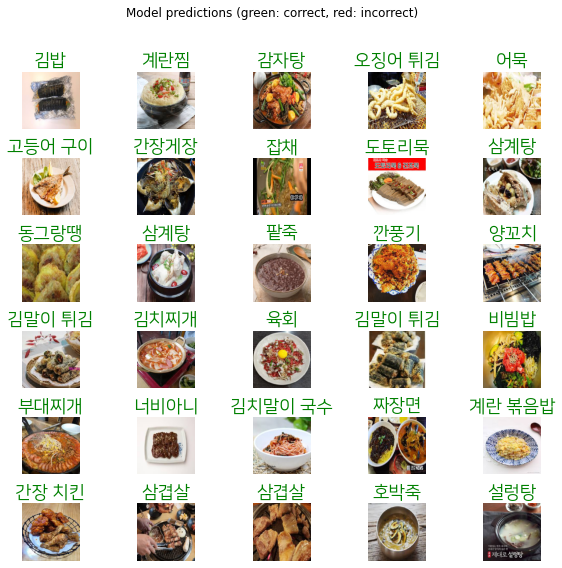

In [48]:
import matplotlib.font_manager as fm
font_path = r'C:\Users\jeongin\Downloads\NanumFontSetup_TTF_SQUARE\NanumSquareR.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), fontproperties=fontprop, color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### 8. 모델 내보내기

In [51]:
import time
t = time.time()

export_path = "/my_models/mobilenetv2_tl_findata100_agmentation{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /my_models/mobilenetv2_tl_findata100_agmentation1606802493\assets


INFO:tensorflow:Assets written to: /my_models/mobilenetv2_tl_findata100_agmentation1606802493\assets


'/my_models/mobilenetv2_tl_findata100_agmentation1606802493'

### 9. 저장된 모델 변환(tflite로)

In [52]:
import tensorflow as tf

saved_model_dir = export_path

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('mobilenetv2_tl_findata100_tune.tflite', 'wb') as f:
  f.write(tflite_model)

### 10. Test

In [82]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_image_data = image_generator.flow_from_directory('./food_test',batch_size=32, target_size=IMAGE_SHAPE)

Found 1003 images belonging to 100 classes.


In [84]:
# loss, accuracy = model.evaluate(test_image_data)